In [1]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import sys
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import v2

if 'google.colab' in sys.modules:
    !pip install torchsummary
    !pip install albumentationsx
    !pip install torch_lr_finder

import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torchsummary import summary
from tqdm import tqdm

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

from model_v1 import ResNet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 27.4 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.33 which is incompatible.


In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(f"Cuda available = {is_cuda}, Using device = {device}")

Cuda available = False, Using device = cpu


In [4]:
# Mean and Standard Deviation of CIFAR-100 dataset
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD = (0.2675, 0.2565, 0.2761)
if 'google.colab' in sys.modules:
    BATCH_SIZE = 1024
else:
    BATCH_SIZE = 32
CIFAR100_LABELS = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]
logger.info(f"Lenth of class names = {len(CIFAR100_LABELS)}")
GET_DATASET_STATS_FLAG = True

In [6]:
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # CIFAR100 gives PIL image -> convert to numpy
        img = np.array(img)
        # Apply Albumentations
        augmented = self.transform(image=img)
        return augmented["image"]

# Denormalization function for viz/stats (add this helper)
def denormalize(tensor_img, mean=CIFAR100_MEAN, std=CIFAR100_STD):
    """Denormalize tensor for display (assumes C x H x W, values in [-2,2] approx)."""
    tensor_img = tensor_img.clone()  # Avoid modifying original
    for t, m, s in zip(tensor_img, mean, std):
        t.mul_(s).add_(m)  # Unnormalize
    return torch.clamp(tensor_img, 0, 1)  # Clamp to [0,1]

train_transforms = AlbumentationsTransform(A.Compose([
    A.Resize(32, 32),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=(-0.0625, 0.0625),
        scale_limit=(-0.1, 0.1),
        rotate_limit=(-15, 15),
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_CONSTANT,
        rotate_method="largest_box",
        p=0.5),
    A.CoarseDropout(
        num_holes_range=(1,1),
        hole_height_range=(5, 15),
        hole_width_range=(5, 15),
        fill=0,
        p=0.5
    ),
    A.Normalize(mean=CIFAR100_MEAN, std=CIFAR100_STD),
    A.ToTensorV2(),
]))

test_transforms = AlbumentationsTransform(A.Compose([
    A.Resize(32, 32),
    A.Normalize(mean=CIFAR100_MEAN, std=CIFAR100_STD),
    A.ToTensorV2(),
]))

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
cifar_train_dataset = datasets.CIFAR100(
    root='../../',
    train=True,
    download=True,
    transform=train_transforms,
)

cifar_test_dataset = datasets.CIFAR100(
    root='../../',
    train=False,
    download=True,
    transform=test_transforms,
)

train_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': True,  'num_workers': 0, 'pin_memory': is_cuda}
test_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': False,  'num_workers': 0, 'pin_memory': is_cuda}

train_loader = torch.utils.data.DataLoader(cifar_train_dataset, **train_kwargs)
test_loader  = torch.utils.data.DataLoader(cifar_test_dataset,  **test_kwargs)

100%|██████████| 169M/169M [00:02<00:00, 75.3MB/s]


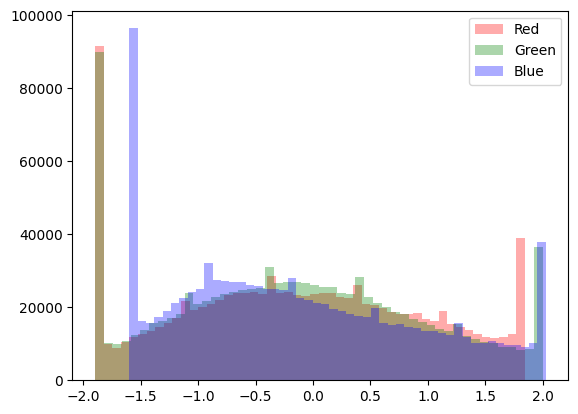

In [7]:
if GET_DATASET_STATS_FLAG:
    # Note: This computes stats on transformed (augmented + normalized) data, which isn't ideal for verifying raw mean/std.
    # If you want raw stats, use a temp dataset without transforms/normalize.
    imgs = []
    for index, item in enumerate(cifar_train_dataset):
        # Sampling 1000 images only
        if index > 1000:
            break
        else:
            imgs.append(item[0])
    # imgs = [item[0] for item in cifar_train_dataset]
    imgs = torch.stack(imgs, dim=0).numpy()
    imgs_r = imgs[:,0,:,:].flatten()
    imgs_g = imgs[:,1,:,:].flatten()
    imgs_b = imgs[:,2,:,:].flatten()
    logger.info(f"Flatten images size {imgs_r.shape}, {imgs_g.shape}, {imgs_b.shape}")

    plt.hist(imgs_r, bins=50, alpha=0.33, color='r', label='Red')
    plt.hist(imgs_g, bins=50, alpha=0.33, color='g', label='Green')
    plt.hist(imgs_b, bins=50, alpha=0.33, color='b', label='Blue')
    plt.legend()
    plt.show()

In [8]:
def dataset_visualizer(dataset_loader, n_images=12):
    """Visualize a few samples from the dataset loader."""
    batch_data, batch_label = next(iter(dataset_loader))
    n_images = min(n_images, len(batch_data))

    fig = plt.figure(figsize=(10, 8))
    for i in range(n_images):
        plt.subplot(3, 4, i+1)
        plt.tight_layout()
        image_data = batch_data[i].cpu()
        # Denormalize first (expects C x H x W)
        image_data = denormalize(image_data, mean=CIFAR100_MEAN, std=CIFAR100_STD)
        # Then permute to H x W x C for visualization
        image_data = image_data.permute(1, 2, 0)
        plt.imshow(image_data)
        plt.title(CIFAR100_LABELS[batch_label[i].item()])
        plt.xticks([])
        plt.yticks([])
    plt.show()

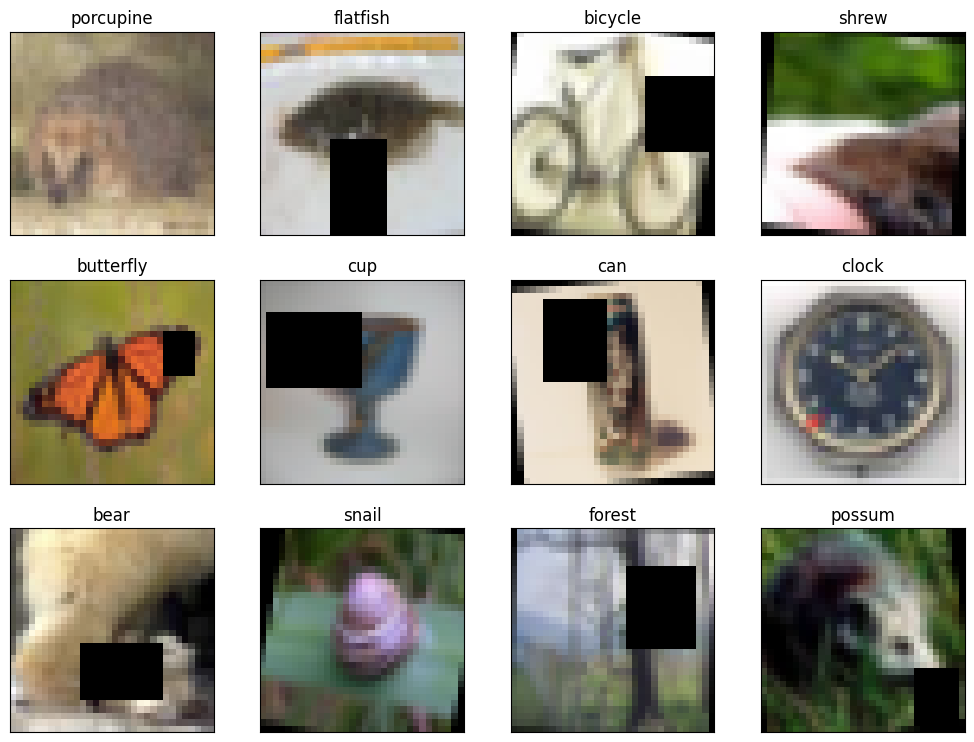

In [9]:
dataset_visualizer(train_loader)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(layers=[2,2,3,2], num_classes=100, use_depthwise=(False, False, True, True)).to(device)

dummy_data = torch.randn(5, 3, 32, 32).to(device)
dummy_output = model(dummy_data)
print("Output shape:", dummy_output.shape)  # should be [5, 100]
summary(model, input_size=(3, 32, 32), device=str(device))

Output shape: torch.Size([5, 100])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
    

In [9]:
from torch_lr_finder import LRFinder

model = ResNet(layers=[2,2,3,2], num_classes=100, use_depthwise=(False, False, True, True)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state
#4e-3

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
# Learning rate chosen
lr_from_lr_finder = 4E-3
logger.info(f"Learning rate for one cycle LR = {lr_from_lr_finder}")

In [11]:
# ============================================================
# 1️⃣ Checkpoint utilities
# ============================================================

def save_checkpoint(model, optimizer, scheduler, epoch, best_loss, path):
    state = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict(),
        'best_loss': best_loss
    }
    torch.save(state, path)
    logger.info(f"✅ Checkpoint saved at epoch {epoch+1} to {path}")


def load_checkpoint(model, optimizer, scheduler, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    scheduler.load_state_dict(checkpoint['scheduler_state'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['best_loss']
    logger.info(f"✅ Resumed from checkpoint: epoch {start_epoch}, best loss {best_loss:.4f}")
    return start_epoch, best_loss

In [12]:
# ============================================================
# 2️⃣ Training Loop (OneCycleLR integrated)
# ============================================================
criterion = nn.CrossEntropyLoss()
train_loss_data = []
train_accuracy = []
test_loss_data = []
test_accuracy = []
learning_rate_over_steps = []

best_loss = float('inf')   # initialize with infinity

def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    total = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()  # OneCycleLR updates per batch

        learning_rate_over_steps.append(optimizer.param_groups[0]['lr'])

        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        pbar.set_description(desc=f'loss={loss.item():.4f} batch_id={batch_idx}')

    # Epoch-level stats
    avg_loss = running_loss / len(train_loader)
    acc = 100. * correct / total

    train_loss_data.append(avg_loss)
    train_accuracy.append(acc)

    print(f'\nTrain set (epoch {epoch}): Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({acc:.2f}%)\n')

# ============================================================
# 3️⃣ Testing Loop
# ============================================================

def test(model, device, test_loader, epoch):
    global best_loss  # to update across epochs
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_data.append(test_loss)
    acc = 100. * correct / len(test_loader.dataset)
    test_accuracy.append(acc)

    print(f'Test set (epoch {epoch}): Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')

    # ✅ Save best model by lowest test loss
    if test_loss < best_loss:
        best_loss = test_loss
        save_dir = "/content/drive/MyDrive/CIFAR100" if 'google.colab' in sys.modules else "."
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pt"))
        print(f"✅ Saved new best model at epoch {epoch} with loss {best_loss:.4f}")

    return test_loss


In [ ]:
# ============================================================
# 3️⃣ Model, optimizer, scheduler setup
# ============================================================

# Example: customize your ResNet to use partial depthwise convs
model = ResNet(layers=[2, 2, 3, 2], num_classes=100,
               use_depthwise=(False, False, True, True)).to(device)

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# You already ran LR Finder earlier and got:
max_lr = lr_from_lr_finder   # Use from LR Finder output
total_epochs = 40 # Full plan (even if train 20+20)
scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_loader),
    epochs=total_epochs,
    pct_start=0.3,
    anneal_strategy="cos",
    div_factor=25.0,
    final_div_factor=1e4,
)

# ============================================================
# 4️⃣ Resume if checkpoint exists
# ============================================================

start_epoch = 0
save_dir = "/content/drive/MyDrive/CIFAR100" if 'google.colab' in sys.modules else "."
os.makedirs(save_dir, exist_ok=True)
save_dir_file_name = os.path.join(save_dir, "checkpoint.pt")
if os.path.exists(save_dir_file_name):
    logger.info("Found checkpoint, loading checkpoint ...")
    start_epoch, best_loss = load_checkpoint(model, optimizer, scheduler, save_dir_file_name, device)
else:
    best_loss = float("inf")

# ============================================================
# 5️⃣ Main training loop
# ============================================================

for epoch in range(start_epoch, total_epochs):
    train(model, device, train_loader, optimizer, scheduler, epoch)
    test_loss = test(model, device, test_loader, epoch)
    save_checkpoint(model, optimizer, scheduler, epoch, best_loss, save_dir_file_name)

loss=4.5689 batch_id=7:  16%|█▋        | 8/49 [09:30<48:19, 70.72s/it]

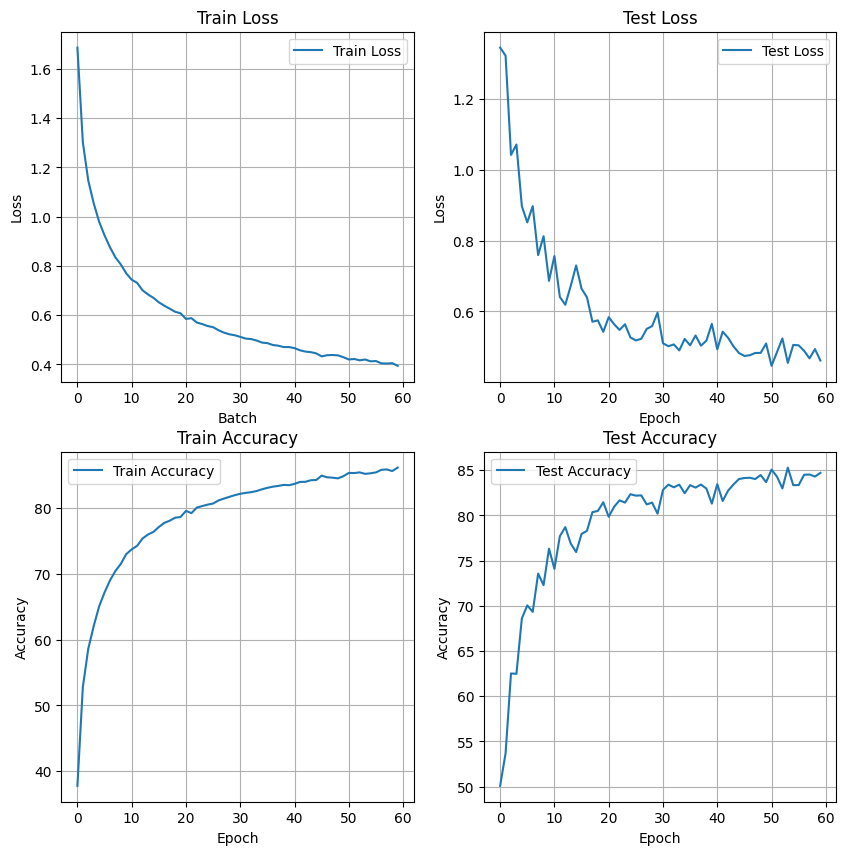

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].plot(train_loss_data, label='Train Loss')
axs[0,0].set_xlabel('Batch')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title('Train Loss')
axs[0,0].grid(True)
axs[0,0].legend()

axs[0,1].plot(test_loss_data, label='Test Loss')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title('Test Loss')
axs[0,1].grid(True)
axs[0,1].legend()

axs[1,0].plot(train_accuracy, label='Train Accuracy')
axs[1,0].set_xlabel('Epoch')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].set_title('Train Accuracy')
axs[1,0].grid(True)
axs[1,0].legend()

axs[1,1].plot(test_accuracy, label='Test Accuracy')
axs[1,1].set_xlabel('Epoch')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].set_title('Test Accuracy')
axs[1,1].grid(True)
axs[1,1].legend()

plt.show()